# BERT-Style Pretraining Run on Romeo and Juliet

## Installs and Imports

In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=398e6a3ab54d11d7905058d8d51b970351ef1835f18fed789d6e40c1d3618ae9
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 103.9

In [1]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import torch

torch.manual_seed(4321)
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Network Architecture

In [3]:
import torch
import torch.nn as nn
import numpy as np

class GraphConvolution(torch.nn.Module):
    def __init__(self, character_embedding_dim, edge_dim):
        super(GraphConvolution, self).__init__()

        self.ce_dim = character_embedding_dim
        self.e_dim = edge_dim
        
        self.message_to_listener = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                 torch.nn.LayerNorm(character_embedding_dim),
                                                 nn.Tanh())
        
        self.message_to_speaker = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                torch.nn.LayerNorm(character_embedding_dim),
                                                nn.Tanh())
        
        self.listener_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), 
                                             nn.Tanh())
        self.speaker_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), 
                                            nn.Tanh())

    # character_embeddings: (n_batch x n_characters x character_dim)
    # dialogue_embeddings : (n_batch x edge_dim)
    # speaker: (n_batch x 1)
    # listener: (n_batch x 1)
    def forward(self, character_embeddings, dialogue_embeddings, speakers, listeners):
        '''
          -> (speakers intersect listeners) should be an empty set!
        '''
        speaker_features = character_embeddings[np.arange(len(speakers)), speakers, :]
        listener_features = character_embeddings[np.arange(len(listeners)), listeners, :]

        speaker_listener_dialogue =  torch.cat((speaker_features - listener_features, dialogue_embeddings), dim=-1)

        # Residual connection included to avoid dying gradients (removed)
        updated_speakers = speaker_features + self.speaker_update(speaker_features + self.message_to_listener(speaker_listener_dialogue))
        updated_listeners = listener_features + self.listener_update(listener_features + self.message_to_speaker(speaker_listener_dialogue))

        out = character_embeddings.clone()
        out[:, speakers, :] = updated_speakers
        out[:, listeners, :] = updated_listeners

        return out


class GCLWithHeadBert(torch.nn.Module):
  def __init__(self, character_embedding_dim, bert_dim, edge_dim, out_dim):
    super(GCLWithHeadBert, self).__init__()

    self.bert_dim = bert_dim
    self.head = nn.Linear(2 * character_embedding_dim, out_dim)
    self.edge_translator = nn.Linear(bert_dim, edge_dim)
    self.gcn_layer = GraphConvolution(character_embedding_dim, edge_dim)
    self.activation = nn.Tanh()

  # character_embeddings: (n_batch x n_characters x character_dim)
  # embedding : (n_batch x bert_dim)
  # speaker: (n_batch x 1)
  # listener: (n_batch x 1)

  # updated_embeddings: (n_batch x n_characters x character_dim)
  # linear_layer_out: (n_batch x out_dim)
  def forward(self, character_embeddings, embedding, speakers, listeners):
    edge_feature = self.activation(self.edge_translator(embedding.detach()))
    updated_embeddings = self.gcn_layer(character_embeddings, edge_feature, speakers, listeners)
    linear_layer_out = self.activation(self.head(torch.cat((updated_embeddings[np.arange(len(speakers)), speakers, :], 
                                                            updated_embeddings[np.arange(len(listeners)), listeners, :]), axis=1)))
    
    return updated_embeddings, linear_layer_out

class GraphRNN(torch.nn.Module):
    def __init__(self, character_embedding_dim, bert_dim, edge_dim, pred_size, bptt_term=20):
        super(GraphRNN, self).__init__()

        self.bptt_term = bptt_term
        self.pred_size = pred_size
        self.graph_layer = GCLWithHeadBert(character_embedding_dim, bert_dim, edge_dim, pred_size)

    # character_embeddings: (n_batch x n_characters x character_dim)
    # dialogue_sequence: (n_batch x length_dialogue x (1 + 1 + bert_dim))

    # character_embeddings: (n_batch x n_characters x character_dim)
    # lin_predictions: (n_batch, length_dialogue x pred_size)
    def forward(self, character_embeddings, dialogue_sequence):
        lin_predictions = torch.zeros((dialogue_sequence.shape[0], dialogue_sequence.shape[1], self.pred_size))


        for i in range(dialogue_sequence.shape[1]):
          values = dialogue_sequence[:, i, :]
          speakers = values[:, 0].int()
          listeners = values[:, 1].int()
          dialogues = values[:, 2:]

          character_embeddings, linear_out = self.graph_layer(character_embeddings, dialogues, speakers, listeners)

          # BPTT Truncated Sliding window (window width = step width)
          if i % self.bptt_term == 0:
            character_embeddings = character_embeddings.detach()
            linear_out = linear_out.detach()

          lin_predictions[:, i, :] = linear_out

        return character_embeddings, lin_predictions


## Data Import and Wrangling

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_dialogs = pd.read_csv('rj_vadr_bert.csv').drop(columns=["Unnamed: 0"])
character_enum = pd.DataFrame(df_dialogs["speaker"].unique()).reset_index().rename(columns={0:'character'})
df_dialogs_with_speaker_enumeration = pd.merge(left=df_dialogs,
                                       right=character_enum,
                                       left_on="speaker",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'speaker_index'}).drop(columns=['character'])
df_dialogs_with_listener_enumeration = pd.merge(left=df_dialogs_with_speaker_enumeration,
                                       right=character_enum,
                                       left_on="listener",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'listener_index'}).drop(columns=['character'])
data_d = df_dialogs_with_listener_enumeration[['speaker', 'listener', 'speaker_index', 'listener_index', 'dialogue', 'dialogue_sentiment', 'avg_sentiment', 'bert']]
data = data_d.T.drop_duplicates().T
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,speaker,listener,speaker_index,listener_index,dialogue,dialogue_sentiment,avg_sentiment,bert
0,CHORUS,SAMPSON,0,1,"Two households, both alike in dignity, In fair...",-0.5719,-0.5719,"[-0.062187887728214264, 0.04341184347867966, 0..."
1,SAMPSON,CHORUS,1,0,"Gregory, on my word, we’ll not carry coals.",0.0,0.0,"[-0.14115169644355774, 0.5629909634590149, -0...."
2,SAMPSON,GREGORY,1,2,"Gregory, on my word, we’ll not carry coals.",0.0,-0.062038,"[-0.14115169644355774, 0.5629909634590149, -0...."
3,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
4,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
...,...,...,...,...,...,...,...,...
1681,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1682,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1683,CAPULET,MONTAGUE,7,9,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,-0.127267,"[-0.21812646090984344, 0.143050417304039, -0.1..."
1684,CAPULET,PRINCE,7,11,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,0.062967,"[-0.21812646090984344, 0.143050417304039, -0.1..."


In [6]:
def character_indices(c_enum):
  return {index: name for index, name in enumerate(c_enum['character'])}

def story_to_tensor(df):
  dialogues = np.array([[float(val) for val in be.strip('][').split(', ')] for be in df['bert']])
  speakers = np.array([int(val) for val in df['speaker_index']])[:, np.newaxis]
  listeners = np.array([int(val) for val in df['listener_index']])[:, np.newaxis]

  sentiments = np.array([float(val) for val in df['dialogue_sentiment']])[:, np.newaxis]

  combined = np.concatenate((speakers, listeners, dialogues), axis=1)

  return torch.tensor(combined), torch.tensor(sentiments).float().to(torch_device)

def mask_tensor(tensor, mask_token, mask_prob, repeat_shape):
  masks_rows = torch.zeros((repeat_shape, tensor.shape[0])).type(torch.bool)

  all_examples = tensor.repeat(repeat_shape, 1, 1).to(torch_device).float()
  all_labels = rj_sentiments.repeat(repeat_shape, 1, 1).to(torch_device)

  for i in range(repeat_shape):
    mask_rows = (torch.rand((tensor.shape[0])).to(torch_device) <= mask_prob)
    all_examples[i, mask_rows, 2:] = mask_token
    masks_rows[i] = mask_rows

  return all_examples, all_labels, mask_rows

In [7]:
# Reduce the number of dialogues seen in story (if not None)
n_dialogues = None

# Get tensor representation of story and truncate to fewer dialogues
character_translation = character_indices(character_enum)
rj_combined, rj_sentiments = story_to_tensor(data)

if n_dialogues is not None:
  rj_combined, rj_sentiments = rj_combined[:n_dialogues], rj_sentiments[:n_dialogues]

mask_token = 5 * torch.ones((rj_combined.shape[-1] - 2)).to(torch_device).float()
total_examples = 100
mask_prob = 0.1

# Repeat and mask dialogues
all_examples, all_labels, mask_rows = mask_tensor(rj_combined, mask_token, mask_prob, total_examples)

# Batching, test and training datasets
train_percent = 0.8

train_size = int(train_percent * all_examples.shape[0])
test_size = int(1 - train_percent * all_examples.shape[0])

train_data = all_examples[:train_size]
test_data = all_examples[train_size:]

train_labels = all_labels[:train_size]
test_labels = all_labels[train_size:]

print(rj_combined.shape, rj_sentiments.shape)
print(all_examples.shape, all_labels.shape)

torch.Size([1686, 770]) torch.Size([1686, 1])
torch.Size([100, 1686, 770]) torch.Size([100, 1686, 1])


## Training

In [8]:
import tqdm
import matplotlib.pyplot as plt

def train(model, criterion, optimizer, train_data, train_labels, mask_rows, n_epochs, n_characters, 
          character_embedding_dim, n_batch, gradient_clipping_threshold=1.0):
  
  all_losses = []
  character_embeddings = torch.zeros((n_batch, n_characters, character_embedding_dim)).to(torch_device)

  for e in range(n_epochs):
    for i in range(0, train_data.shape[0], n_batch):
      print(i)
    
      labels = train_labels[i:i+n_batch].to(torch_device)
      data = train_data[i:i+n_batch].to(torch_device)
      batch_masked = mask_rows[i:i+n_batch]

      cu_updated, lin_pred = model(character_embeddings, data)
      
      # Compute and print loss
      loss = criterion(lin_pred.to(torch_device), labels)

      if torch.isnan(loss).any():
        raise RuntimeError('Exploded Loss!')

      # Zero gradients, perform a backward pass, and update the weights.
      optimizer.zero_grad()
      torch.nn.utils.clip_grad_norm_(grnn_bert.parameters(), gradient_clipping_threshold)
      loss.backward()
      optimizer.step()

      all_losses += [float(loss.cpu().detach().numpy())]


    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.plot(all_losses)
    plt.show()
    
  return model, all_losses, character_embeddings

def test(character_embeddings, model, test_data, criterion, test_labels, n_characters, character_embedding_dim):
  with torch.no_grad():
    _, lin_pred = model(character_embeddings, test_data)
    
    # Compute and print loss
    loss = criterion(lin_pred.to(torch_device), test_labels)
    
  return loss.cpu().detach().numpy()

0
20
40
60


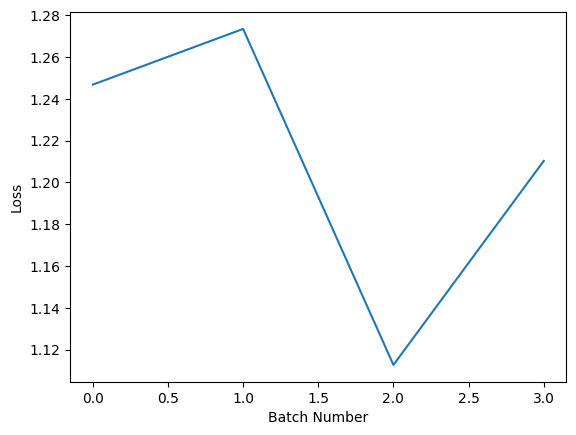

0
20
40
60


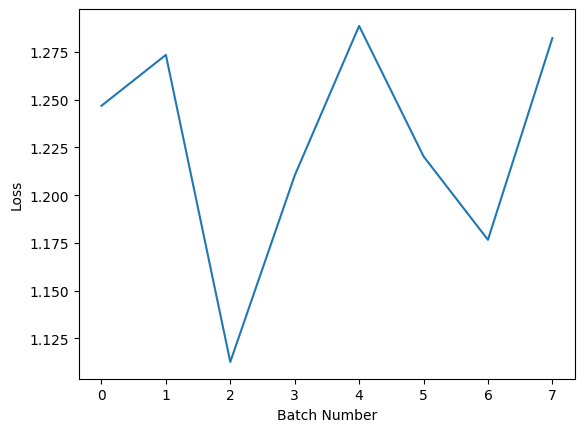

0
20
40
60


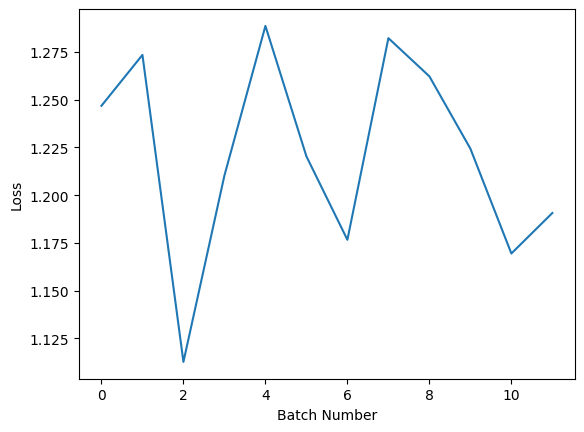

0
20
40
60


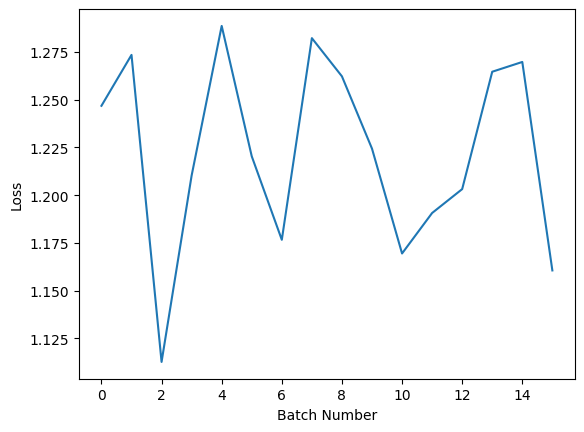

0
20
40
60


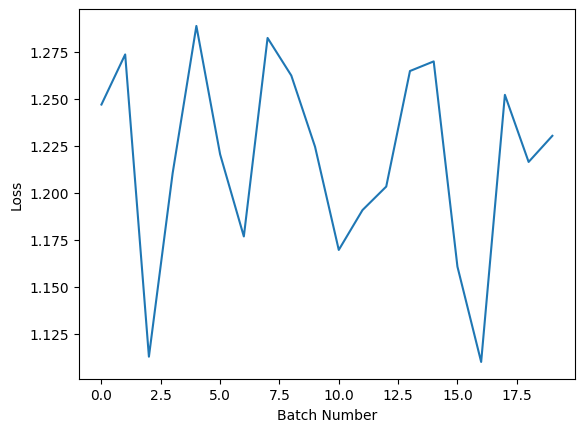

In [9]:
character_embedding_dim = 32
bert_dim = 768
edge_dim = 32
pred_size = 1
n_batch = 20

bptt_term = 20
gradient_clipping_threshold = 0.5
weight_decay = 10
learning_rate = 1e-3

EPOCHS = 5

grnn_bert = GraphRNN(character_embedding_dim, bert_dim, edge_dim, pred_size, bptt_term=bptt_term).to(torch_device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(grnn_bert.parameters(), weight_decay=weight_decay, lr=learning_rate)

n_characters = len(character_enum)

trained_model, training_losses, character_embeddings = train(grnn_bert, criterion, optimizer, train_data, train_labels, mask_rows, EPOCHS, 
                            len(character_enum), character_embedding_dim, n_batch,
                         gradient_clipping_threshold=gradient_clipping_threshold)


In [10]:
test_loss = test(character_embeddings, trained_model, test_data, criterion, test_labels, n_characters, character_embedding_dim)

In [11]:
print('Final test loss', test_loss)

Final test loss 1.2163719


## Visualizing Embeddings

In [ ]:
# create a 2D plot of the vectors
def plot_2d(vectors, labels):
    tsne = TSNE(n_components=2, perplexity=1, random_state=0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)
    labels = labels

    df = px.data.iris()
    fig = px.scatter(x=T[:,0], y=T[:,1], color=labels)
    fig.show()

plot_2d(character_embeddings.cpu().detach().numpy()[0], character_enum['character'])

In [ ]:
print(character_embeddings.cpu().detach().numpy()[0].shape)

(38, 32)
